In [1]:
import yfinance as yf
import pandas_datareader as pdr
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import cufflinks as cf
from sklearn.metrics import mean_absolute_percentage_error
cf.go_offline()

## Data Collection and Data Manipulation

In [2]:
def get_finance_data(stock):
    s = yf.Ticker(stock)
    
    df = s.history(start = '2009-01-31', end='2021-10-22', interval = "1d")
    df = df.drop(['Dividends', 'Stock Splits'], axis=1)

    return df

In [3]:
pypl = get_finance_data('pypl')

In [4]:
pypl

,Open,High,Low,Close,Volume
Date,,,,,
2015-07-06,38.000000,39.750000,36.000000,36.709999,5866600
2015-07-07,37.720001,37.810001,36.000000,36.619999,7359000
2015-07-08,36.340000,36.360001,34.529999,34.700001,5387700
2015-07-09,35.099998,35.520000,33.990002,34.500000,3760100
2015-07-10,34.660000,35.189999,33.980000,34.689999,4472800
...,...,...,...,...,...
2021-10-15,268.700989,269.721008,265.440002,268.350006,5003000
2021-10-18,266.390015,270.440002,264.709991,270.329987,4367100
2021-10-19,271.010010,273.269989,269.834991,271.700012,3985900


In [5]:
pypl_close = pypl[['Close']]

## Data Visualization

In [6]:
pypl_close.iplot(title='Stock Close Prices', fill = True, xTitle='Dates',yTitle='Close Prices', theme='space')

In [7]:
pypl['Volume'].iplot(title='Volume', xTitle='Dates', yTitle='Volume', theme='space')

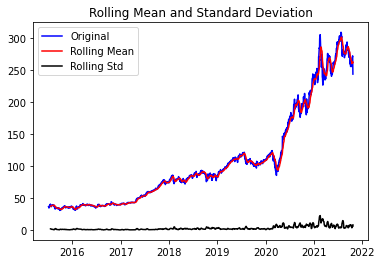

Results of dickey fuller test
Test Statistics                   0.174571
p-value                           0.970799
No. of lags used                 19.000000
Number of observations used    1568.000000
critical value (1%)              -3.434527
critical value (5%)              -2.863385
critical value (10%)             -2.567752
dtype: float64


In [8]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(pypl_close)

<Figure size 432x288 with 0 Axes>

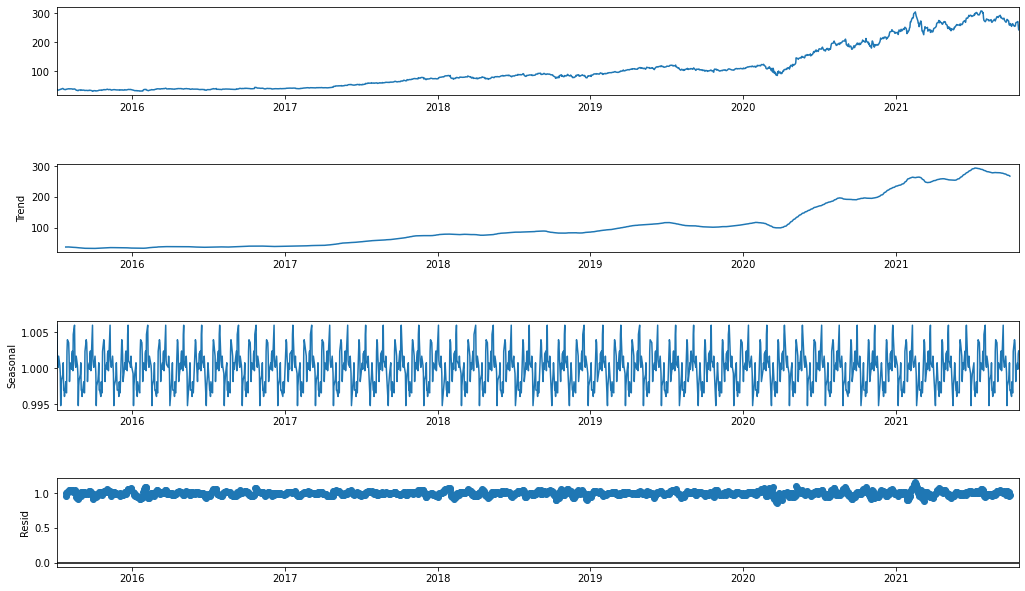

In [9]:
result = seasonal_decompose(pypl_close, model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

## Modeling

In [10]:
pypl_close

,Close
Date,
2015-07-06,36.709999
2015-07-07,36.619999
2015-07-08,34.700001
2015-07-09,34.500000
2015-07-10,34.689999
...,...
2021-10-15,268.350006
2021-10-18,270.329987
2021-10-19,271.700012


## ADF Test

Check for stationary series using the Augmented Dickey Fuller Test.
The ADF test indicates whether or not differencing has to be done or not

In [11]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(pypl_close.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.174571
p-value: 0.970799


## Differencing Term (d)

Since P-value is greater than the significance level, let’s difference the series and see how the autocorrelation plot looks like.

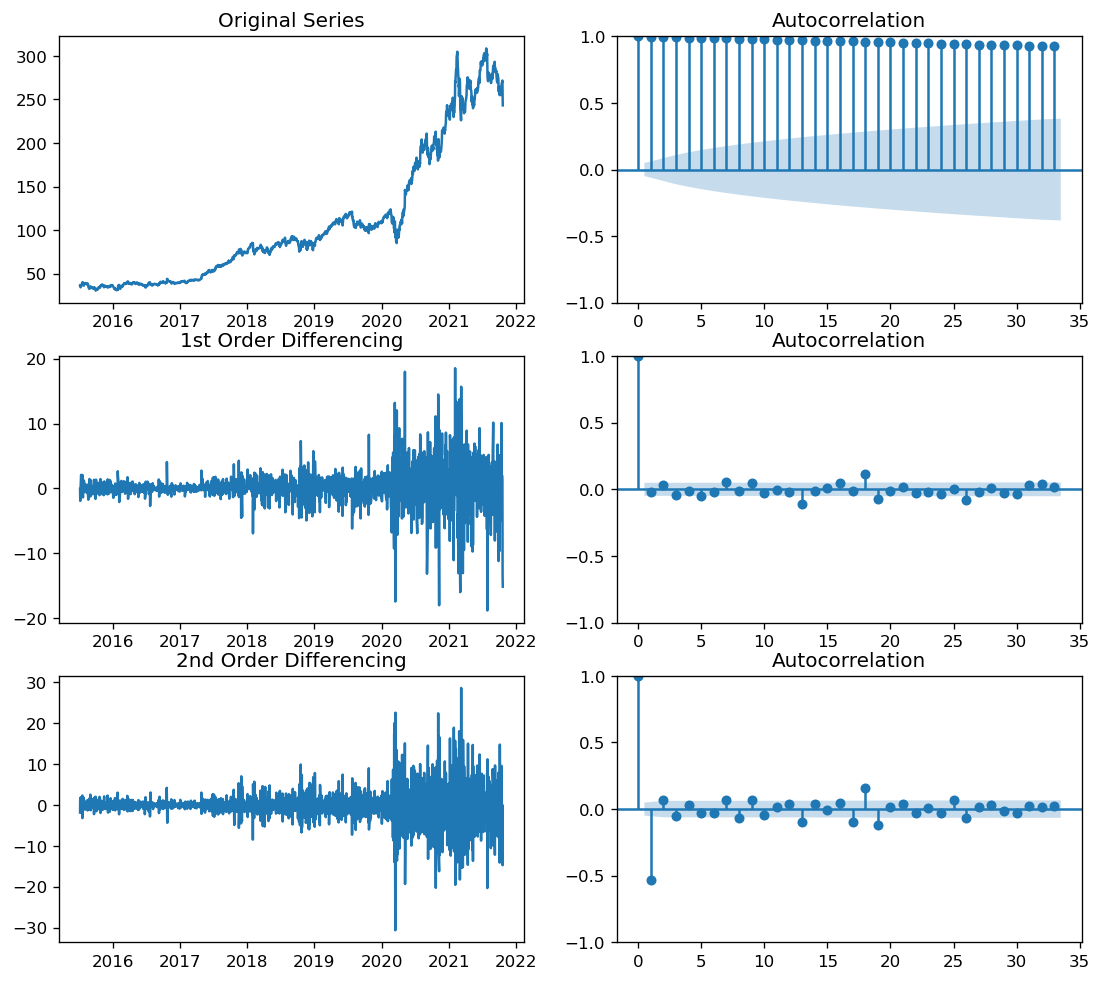

In [12]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(11,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(pypl_close); axes[0, 0].set_title('Original Series')
plot_acf(pypl_close, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(pypl_close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(pypl_close.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(pypl_close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(pypl_close.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced

## AR term (p)

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



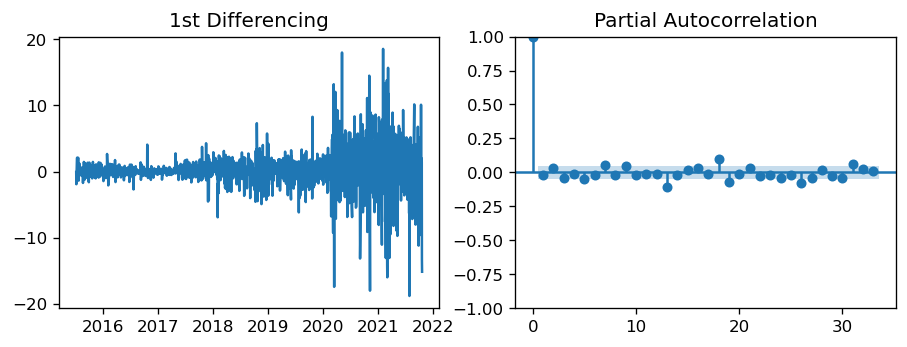

In [13]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(pypl_close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(pypl_close.diff().dropna(), ax=axes[1])

plt.show()

ACF lag 1 is quite significant since is well above the significance line, that is why the lag term will be closer to 1

## MA Term (q)

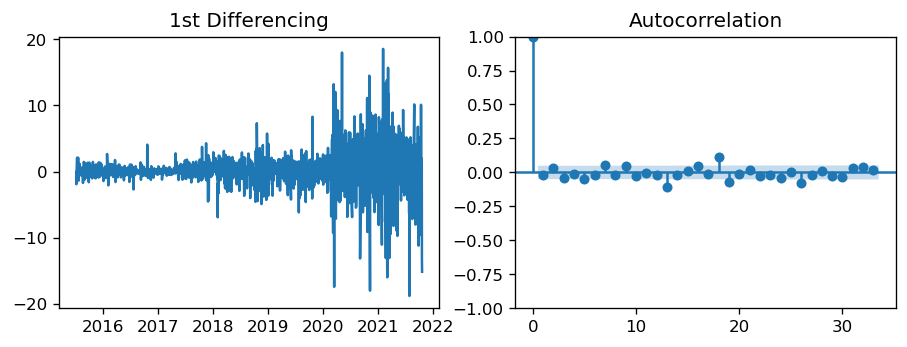

In [14]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})


fig, axes = plt.subplots(1, 2)
axes[0].plot(pypl_close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(pypl_close.diff().dropna(), ax=axes[1])

plt.show()

The 1st lag is well above the signifigance line so the q term will be set to 1

# ARIMA Model

## Train-Test Split

In [15]:
n = int(len(pypl_close) * 0.80)
train = pypl_close[:n]
test = pypl_close[n:]

In [16]:
train

,Close
Date,
2015-07-06,36.709999
2015-07-07,36.619999
2015-07-08,34.700001
2015-07-09,34.500000
2015-07-10,34.689999
...,...
2020-07-14,172.300003
2020-07-15,172.059998
2020-07-16,169.809998


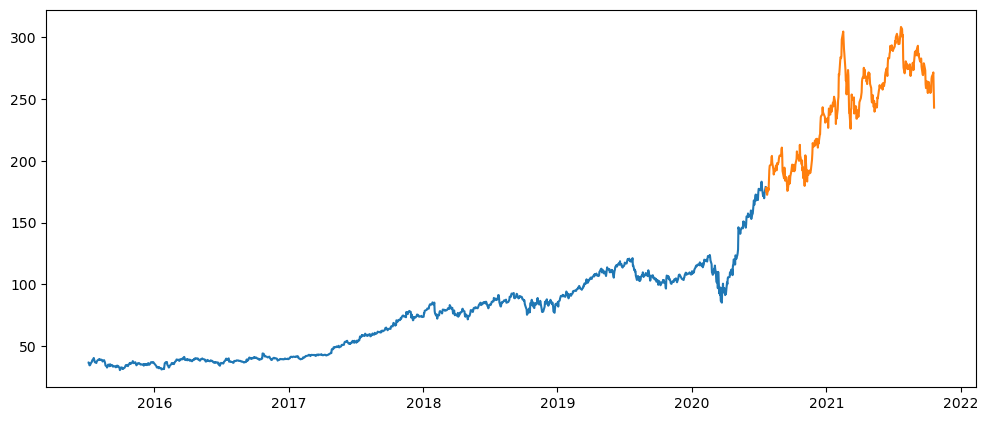

In [17]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')

## Prediction

In [18]:
model = SARIMAX(pypl_close, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1588
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -3996.935
Date:                Wed, 27 Oct 2021   AIC                           7999.870
Time:                        10:25:16   BIC                           8015.979
Sample:                             0   HQIC                          8005.854
                               - 1588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6462      0.180     -3.598      0.000      -0.998      -0.294
ma.L1          0.6150      0.185      3.329      0.001       0.253       0.977
sigma2         9.0184      0.137     65.755      0.0

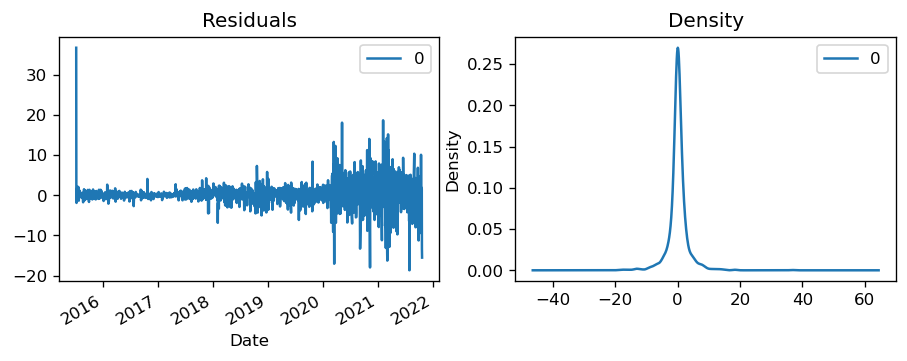

In [19]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [20]:
pred = model_fit.predict(start=pd.to_datetime('2019-04-08'), dynamic=False)
plt.show()

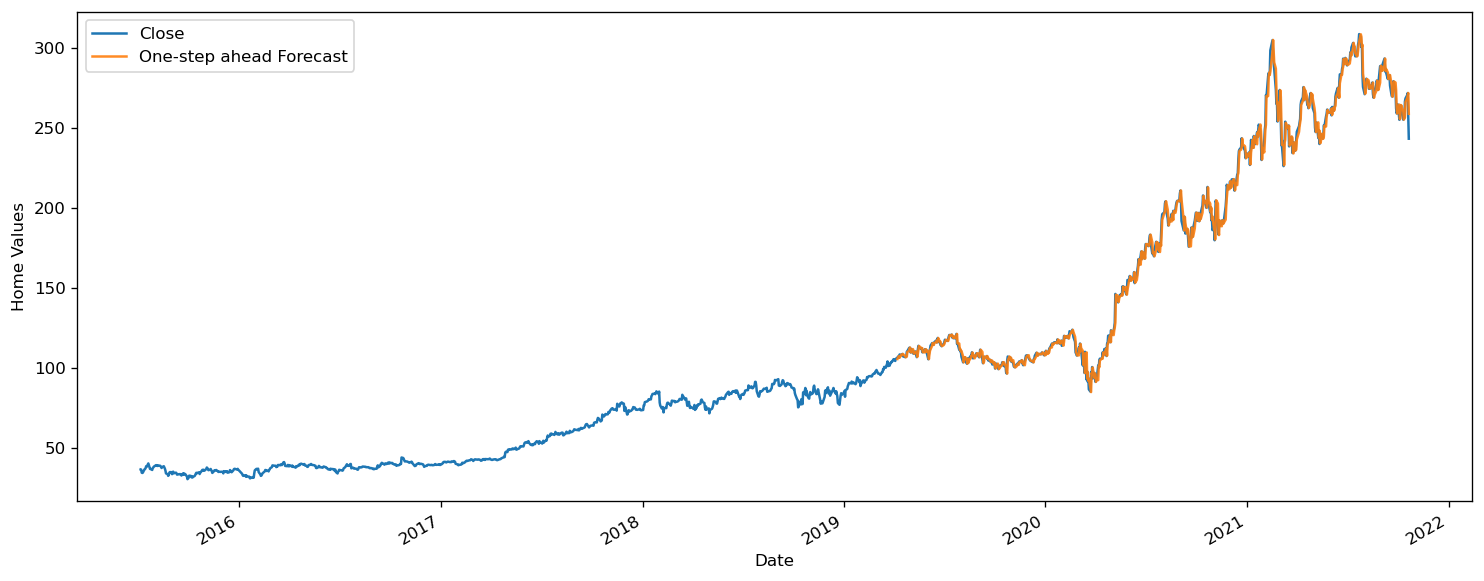

In [21]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = pypl_close.plot(label='observed')

# Plot predicted values
pred.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Home Values')
plt.legend()

plt.show();

In [22]:
value_forecasted = pred
value_truth = pypl_close['Close']['2019-04-08':]

# Compute the root mean square error
mse = ((value_forecasted - value_truth) ** 2).mean()
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of prediction is 4.51


In [23]:
mean_absolute_percentage_error(value_truth, value_forecasted)

0.01790245909196883

# PMDARIMA FOR BETTER MODEL

In [31]:
import pmdarima as pm
from pmdarima.arima import ndiffs
from pmdarima.metrics import smape

In [32]:
kpss_diffs = ndiffs(train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")
# Estimated differencing term: 1

Estimated differencing term: 1


In [33]:
auto = pm.auto_arima(train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5076.589, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5171.622, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5121.649, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5125.124, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5174.245, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5125.057, Time=0.48 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5123.142, Time=0.91 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5124.143, Time=1.70 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5126.831, Time=0.81 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5123.387, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5125.632, Time=0.73 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5092.868, Time=0.91 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5080.153, Time=2.22 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5080.341, Time=0.40 sec

Best model:  ARIMA(2,1,2)(0,0,0)

In [34]:
print(auto.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1270
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -2532.294
Date:                Wed, 27 Oct 2021   AIC                           5076.589
Time:                        10:51:33   BIC                           5107.464
Sample:                             0   HQIC                          5088.187
                               - 1270                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4034      0.176      2.286      0.022       0.058       0.749
ar.L1         -1.7336      0.021    -83.759      0.000      -1.774      -1.693
ar.L2         -0.8723      0.020    -44.151      0.0

In [35]:
model = auto  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in test['Close']:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(test['Close'], forecasts)}")
print(f"SMAPE: {smape(test['Close'], forecasts)}")

KeyboardInterrupt: 

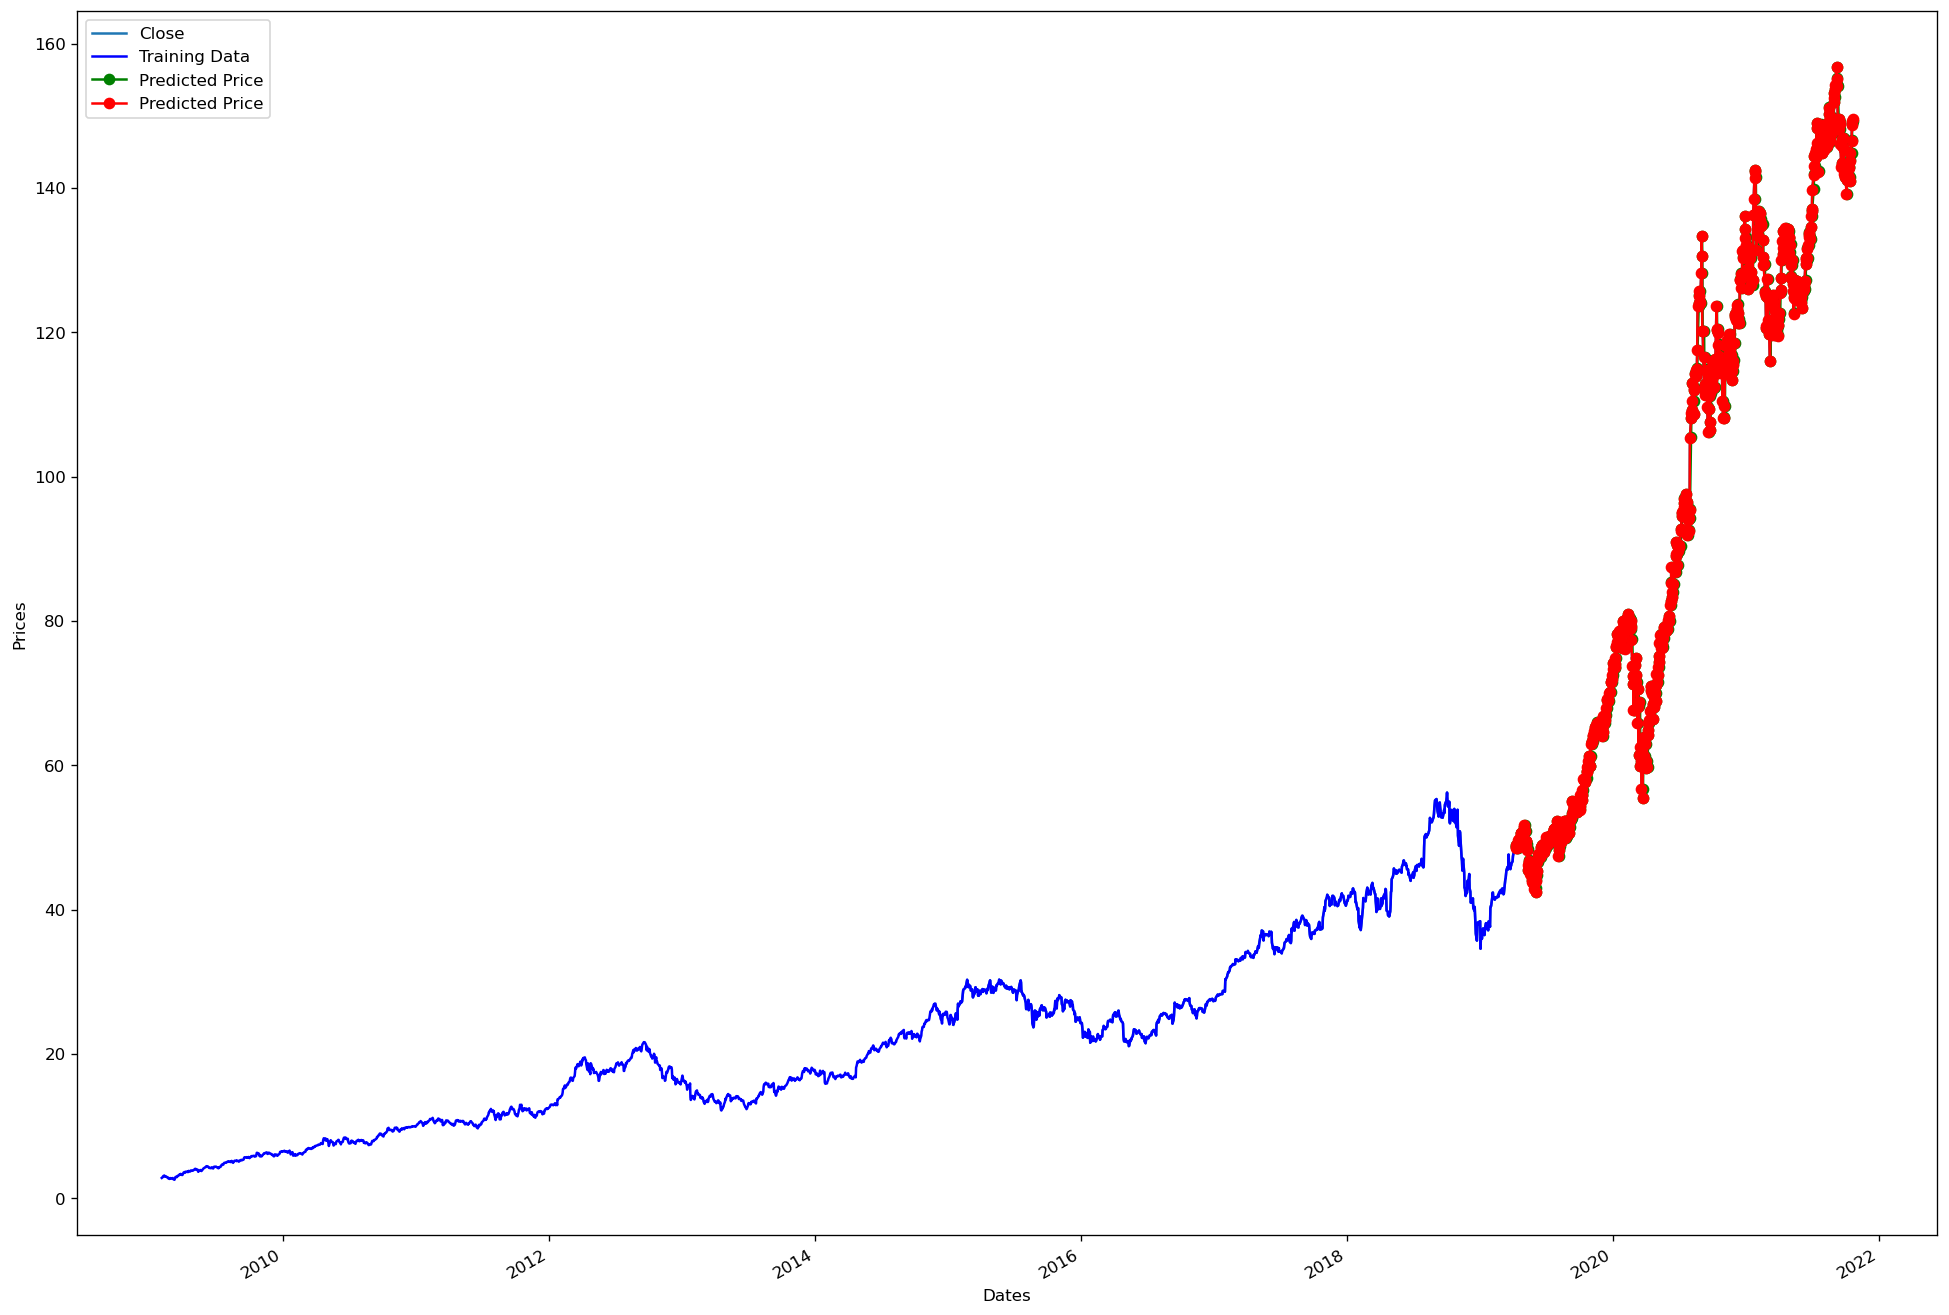

In [26]:
ax = pypl_close.iloc[1500:].plot(label='observed', figsize=(20, 15))
ax.plot(train, color='blue', label='Training Data')
ax.plot(test.index, forecasts, color='green', marker='o',
             label='Predicted Price')
ax.plot(test.index, test, color='red', marker='o', label='Predicted Price')
ax.set_xlabel('Dates')
ax.set_ylabel('Prices')
#axes[0].plot(test_data.index, forecasts, color='green', marker='o',
       #      label='Predicted Price')

plt.legend()
plt.show()

In [30]:
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt(32.336975197113844), 2)))

The Root Mean Squared Error of prediction is 5.69


## SARIMAX PMDARIMA

In [30]:
smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=7.49 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=8930.642, Time=0.16 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=3578.035, Time=2.70 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=6626.817, Time=3.77 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=8984.352, Time=0.11 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=4191.596, Time=0.66 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=3304.696, Time=8.96 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=30.33 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=8.25 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=8883.914, Time=3.18 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=3299.147, Time=13.21 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=3576.830, Time=3.30 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=33.45 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=12.79 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : A

In [31]:
model = smodel  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in test['Close']:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(test['Close'], forecasts)}")
print(f"SMAPE: {smape(test['Close'], forecasts)}")

Mean squared error: 5.53191466565251
SMAPE: 1.7790049949512365


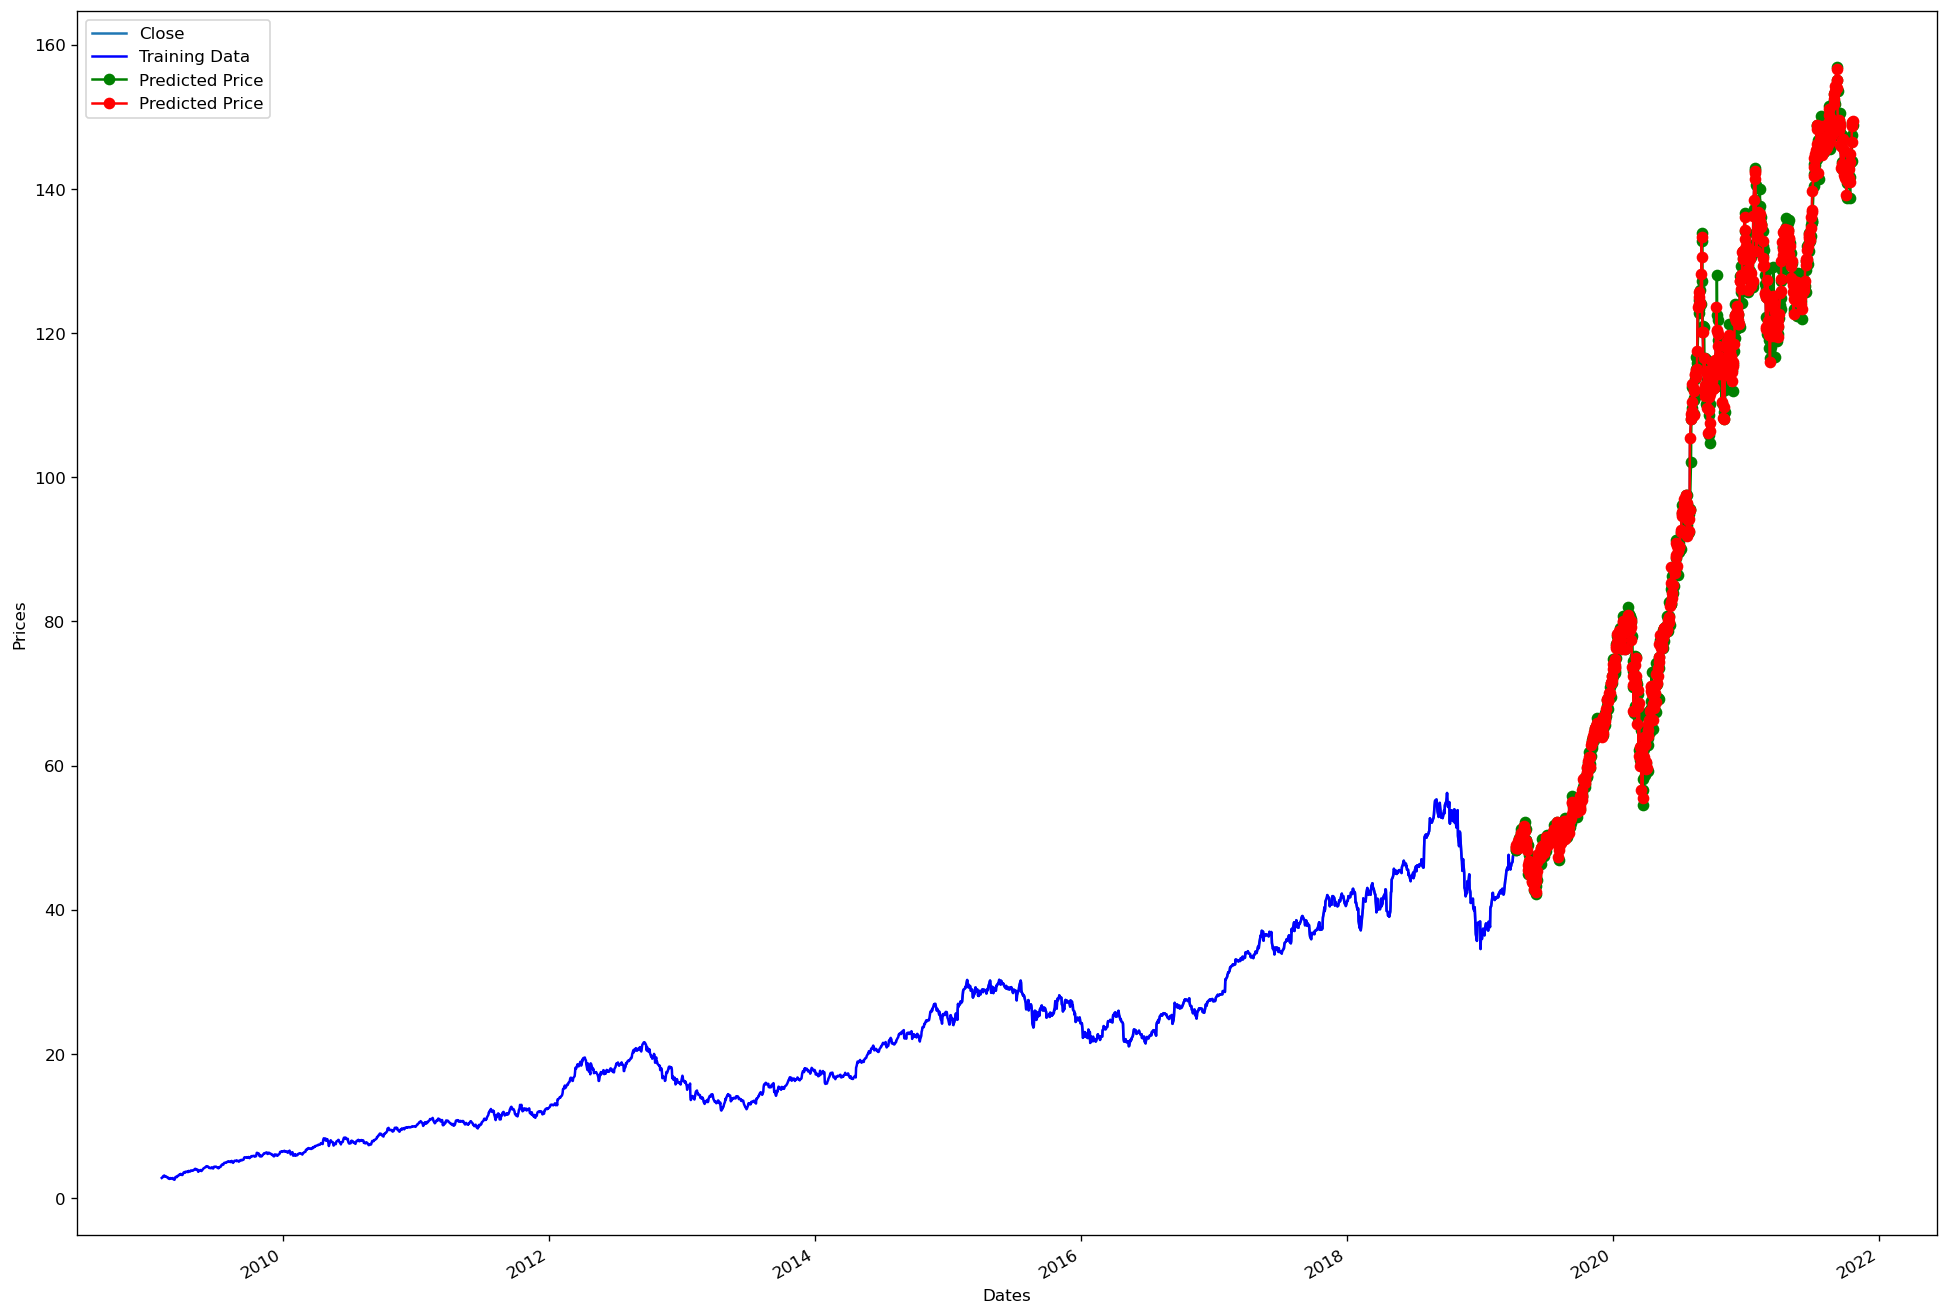

In [32]:
ax = pypl_close.iloc[1500:].plot(label='observed', figsize=(20, 15))
ax.plot(train, color='blue', label='Training Data')
ax.plot(test.index, forecasts, color='green', marker='o',
             label='Predicted Price')
ax.plot(test.index, test, color='red', marker='o', label='Predicted Price')
ax.set_xlabel('Dates')
ax.set_ylabel('Prices')
#axes[0].plot(test_data.index, forecasts, color='green', marker='o',
       #      label='Predicted Price')

plt.legend()
plt.show()

In [33]:
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt('fill in'), 2)))

The Root Mean Squared Error of prediction is 2.35


## FBPROPHET

In [116]:
pypl_close =pypl[['Close']]

In [117]:
pypl = pypl_close.reset_index()

In [118]:
pypl

,Date,Close
0,2009-02-02,2.806142
1,2009-02-03,2.851219
2,2009-02-04,2.868698
3,2009-02-05,2.957934
4,2009-02-06,3.057902
...,...,...
3199,2021-10-15,144.839996
3200,2021-10-18,146.550003
3201,2021-10-19,148.759995
3202,2021-10-20,149.259995


In [119]:
pypl.rename(columns={'Close': 'y', 'Date': 'ds'},inplace=True)
pypl['ds'] = pd.to_datetime(pypl['ds'])
pypl['y']=pypl['y'].astype(float)

In [120]:
df_prophet = Prophet(changepoint_prior_scale=0.15, daily_seasonality=False)
df_prophet.fit(pypl)

In [121]:

fcast_time=365   # 1 year
df_forecast = df_prophet.make_future_dataframe(periods= fcast_time, freq='D')
df_forecast.tail(10)

,ds
3559,2022-10-12
3560,2022-10-13
3561,2022-10-14
3562,2022-10-15
3563,2022-10-16
3564,2022-10-17
3565,2022-10-18
3566,2022-10-19
3567,2022-10-20
3568,2022-10-21


In [122]:
# Forecasting - call the method predict
df_forecast = df_prophet.predict(df_forecast)

In [123]:
df_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3564,2022-10-17,199.751464,186.886429,211.100712
3565,2022-10-18,199.960667,187.431321,211.759375
3566,2022-10-19,200.128034,186.968488,212.210604
3567,2022-10-20,200.258211,186.953266,212.378234
3568,2022-10-21,200.332169,187.436117,212.127445


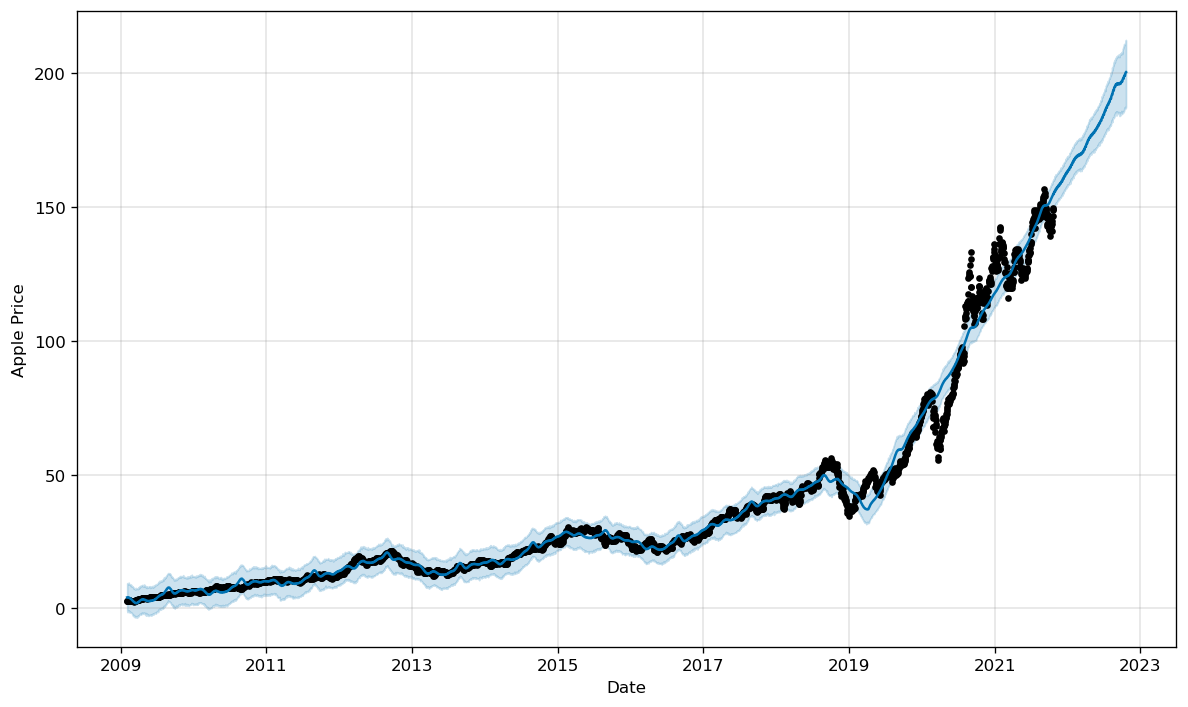

In [124]:
df_prophet.plot(df_forecast, xlabel = 'Date', ylabel = 'Paypal Price');

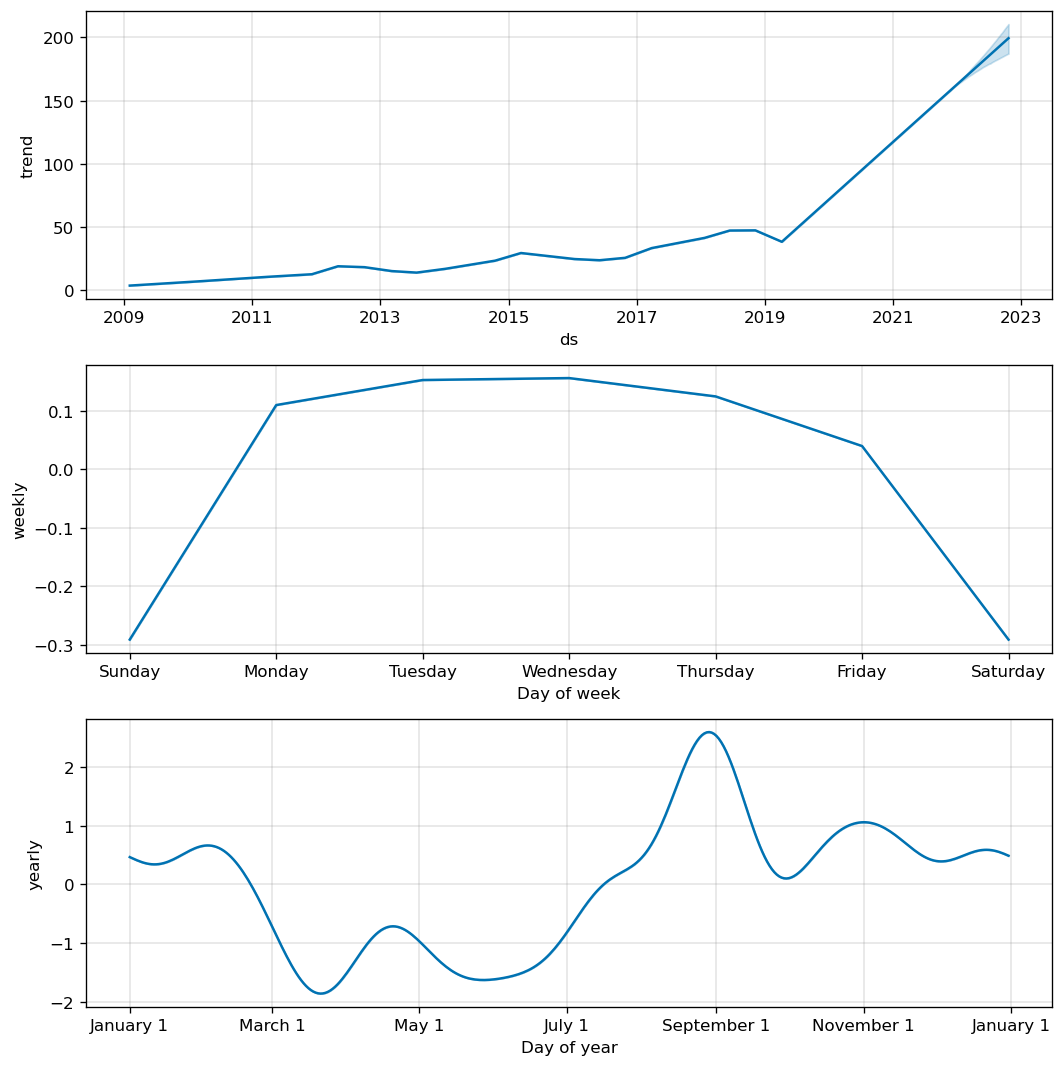

In [125]:

fig2 = df_prophet.plot_components(df_forecast)
plt.show()

In [126]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(df_prophet, horizon = '365 days')

INFO:prophet:Making 18 forecasts with cutoffs between 2012-04-23 12:00:00 and 2020-10-21 00:00:00
100%|██████████| 18/18 [04:39<00:00, 15.52s/it]


In [128]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days 12:00:00,45.238046,6.725923,4.481675,0.109697,0.113532,0.112405,0.151707
1,37 days 00:00:00,46.307919,6.804992,4.544362,0.110811,0.114324,0.113587,0.146018
2,37 days 12:00:00,46.061958,6.786896,4.551771,0.111531,0.115634,0.114326,0.144437
3,38 days 00:00:00,46.489149,6.818295,4.587479,0.112427,0.115882,0.115210,0.141277
4,38 days 12:00:00,46.162220,6.794278,4.581013,0.112847,0.116836,0.115566,0.141277
